# Brain Tumor Classification with CNN

This notebook implements a CNN for binary classification of MRI images as tumor (`yes`) or no tumor (`no`). The dataset has images in `yes` and `no` subfolders, with no masks provided.

**Dependencies**: TensorFlow, NumPy, Matplotlib, OpenCV, Scikit-learn

**Dataset**: MRI images in `data_dir/images/yes` and `data_dir/images/no`.

In [3]:
!pip install tensorflow numpy matplotlib opencv-python scikit-learn streamlit pillow

  Using cached tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 18.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 34.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 37.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 37.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 33.6 MB/s eta 0:00:00
 

In [5]:
!sudo apt-get update && sudo apt-get install -y libgl1

Get:1 https://repo.anaconda.com/pkgs/misc/debrepo/conda stable InRelease [3961 B]
Get:2 https://packages.microsoft.com/repos/microsoft-ubuntu-noble-prod noble InRelease [3600 B]
Get:3 https://dl.yarnpkg.com/debian stable InRelease                           
Get:4 https://packages.microsoft.com/repos/microsoft-ubuntu-noble-prod noble/main all Packages [643 B]
Get:5 https://packages.microsoft.com/repos/microsoft-ubuntu-noble-prod noble/main amd64 Packages [46.0 kB]
Get:6 https://repo.anaconda.com/pkgs/misc/debrepo/conda stable/main amd64 Packages [4557 B]
Get:7 https://dl.yarnpkg.com/debian stable/main amd64 Packages [11.8 kB]       
Get:8 https://dl.yarnpkg.com/debian stable/main all Packages [11.8 kB]         
Get:9 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]      
Get:10 http://archive.ubuntu.com/ubuntu noble InRelease [256 kB]               
Get:11 http://security.ubuntu.com/ubuntu noble-security/multiverse amd64 Packages [23.0 kB]
Get:12 http://archive.ubuntu

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
%matplotlib inline

## 1. Dataset

Define paths to the dataset. Images are in `images/yes` and `images/no` subfolders.

In [9]:
# Dataset paths (adjust based on your dataset structure)
data_dir = '/workspaces/Predict-Brain-Tumor-CNN/data'  # Update to your dataset path
image_dir = os.path.join(data_dir, 'brain_tumor_dataset')
yes_dir = os.path.join(image_dir, 'yes')
no_dir = os.path.join(image_dir, 'no')

# Image parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 16

## 2. Exploratory Data Analysis (EDA)

Analyze the dataset to understand the number of images in `yes` and `no` folders.

In [10]:
# Get list of image files
yes_files = [os.path.join(yes_dir, f) for f in os.listdir(yes_dir) if f.endswith(('.jpg', '.png'))]
no_files = [os.path.join(no_dir, f) for f in os.listdir(no_dir) if f.endswith(('.jpg', '.png'))]
image_files = yes_files + no_files
labels = [1] * len(yes_files) + [0] * len(no_files)  # 1 for tumor, 0 for no tumor

# Check dataset size
print(f'Number of tumor images (yes): {len(yes_files)}')
print(f'Number of non-tumor images (no): {len(no_files)}')
print(f'Total images: {len(image_files)}')

# Check sample image dimensions
sample_img = cv2.imread(image_files[0])
print(f'Sample image shape: {sample_img.shape}')

Number of tumor images (yes): 87
Number of non-tumor images (no): 86
Total images: 173
Sample image shape: (360, 319, 3)


## 3. Plot

Visualize sample images from `yes` and `no` folders to understand the data distribution.

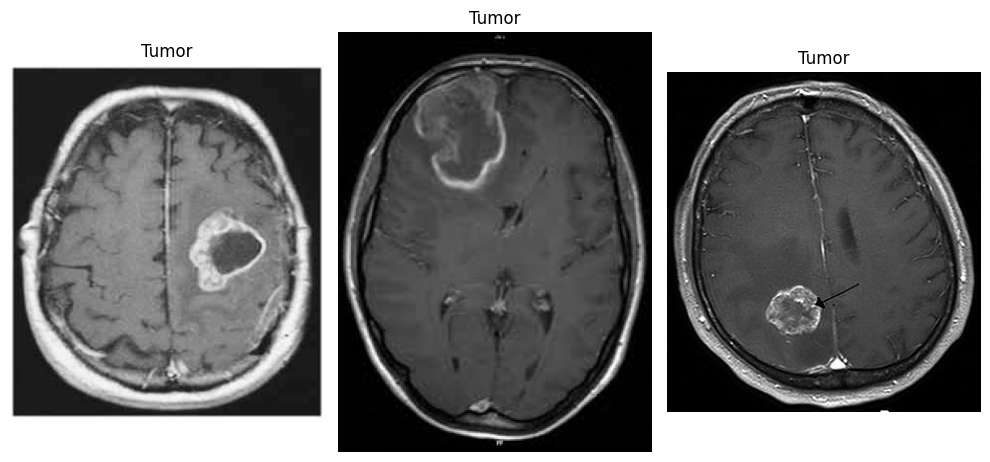

In [11]:
# Plot sample images
plt.figure(figsize=(10, 5))
for i in range(3):
    img = cv2.imread(yes_files[i] if i < len(yes_files) else no_files[i - len(yes_files)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title('Tumor' if i < len(yes_files) else 'No Tumor')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Data Augmentation

Apply data augmentation to training images to increase dataset diversity.

In [12]:
def create_data_generator(img_files, labels, target_size, batch_size, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    # Custom generator for images and labels
    def flow_from_files(datagen, files, labels, target_size, batch_size, shuffle=True, seed=42):
        while True:
            indices = np.arange(len(files))
            if shuffle:
                np.random.seed(seed)
                np.random.shuffle(indices)
            for i in range(0, len(files), batch_size):
                batch_indices = indices[i:i + batch_size]
                batch_files = [files[idx] for idx in batch_indices]
                batch_labels = [labels[idx] for idx in batch_indices]
                batch_images = [cv2.imread(f, cv2.IMREAD_COLOR) for f in batch_files]
                batch_images = [cv2.resize(img, target_size) for img in batch_images]
                batch_images = np.array(batch_images) / 255.0
                batch_labels = np.array(batch_labels)
                yield batch_images, batch_labels

    return flow_from_files(datagen, img_files, labels, target_size, batch_size)

## 5. Data Preprocessing

Apply preprocessing steps: convert BGR to grayscale, apply GaussianBlur, threshold, erode, dilate, and find contours.

In [13]:
def preprocess_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = cv2.imread(img_path)
    # Convert BGR to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply thresholding
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    # Erode and dilate
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(thresh, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)
    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Draw contours on original image (for visualization)
    contour_img = img.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
    # Resize to target size
    processed_img = cv2.resize(img, target_size)  # Use original image for classification
    processed_img = processed_img / 255.0
    return processed_img, contour_img

## 6. Image Loading

Load and preprocess images from `yes` and `no` folders.

In [14]:
# Load images
images = np.array([preprocess_image(f)[0] for f in image_files])
labels = np.array(labels)

print(f'Loaded images shape: {images.shape}')
print(f'Loaded labels shape: {labels.shape}')

Loaded images shape: (173, 128, 128, 3)
Loaded labels shape: (173,)


## 7. Data Splitting (Train, Test, Validation)

Split the dataset into training, validation, and test sets (70% train, 15% validation, 15% test).

In [15]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Training set: {X_train.shape[0]} images')
print(f'Validation set: {X_val.shape[0]} images')
print(f'Test set: {X_test.shape[0]} images')

Training set: 121 images
Validation set: 26 images
Test set: 26 images


## 8. CNN Model Building and Training

Define and train a CNN for binary classification.

In [16]:
def cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create and compile model
model = cnn_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train model
EPOCHS = 20
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
)

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-30 08:37:33.431261: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

2025-07-30 08:37:33.597005: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23789568 exceeds 10% of free system memory.


Epoch 1/20


2025-07-30 08:37:35.042594: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32514048 exceeds 10% of free system memory.
2025-07-30 08:37:35.219150: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23482368 exceeds 10% of free system memory.


1/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4375 - loss: 0.6920

2025-07-30 08:37:35.309754: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25719552 exceeds 10% of free system memory.
2025-07-30 08:37:35.382843: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32514048 exceeds 10% of free system memory.


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 0.5950 - loss: 0.7278 - val_accuracy: 0.8077 - val_loss: 0.5983
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.6860 - loss: 0.6061 - val_accuracy: 0.8077 - val_loss: 0.4905
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.7190 - loss: 0.5248 - val_accuracy: 0.8077 - val_loss: 0.4413
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.7603 - loss: 0.4940 - val_accuracy: 0.7692 - val_loss: 0.4330
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - accuracy: 0.7355 - loss: 0.4944 - val_accuracy: 0.8462 - val_loss: 0.4741
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.8347 - loss: 0.4069 - val_accuracy: 0.8462 - val_loss: 0.4414
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.8512 - loss: 0.3219 - val_accuracy: 0.8077 - val_loss: 0.4078
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.9091 - loss: 0.2441 - val_accuracy: 0.8462 - val_loss: 0.4216
Epo

## 9. Evaluation and Visualization

Evaluate the model on the test set and visualize training/validation metrics and sample predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9231 - loss: 0.3679


Test Accuracy: 92.31%


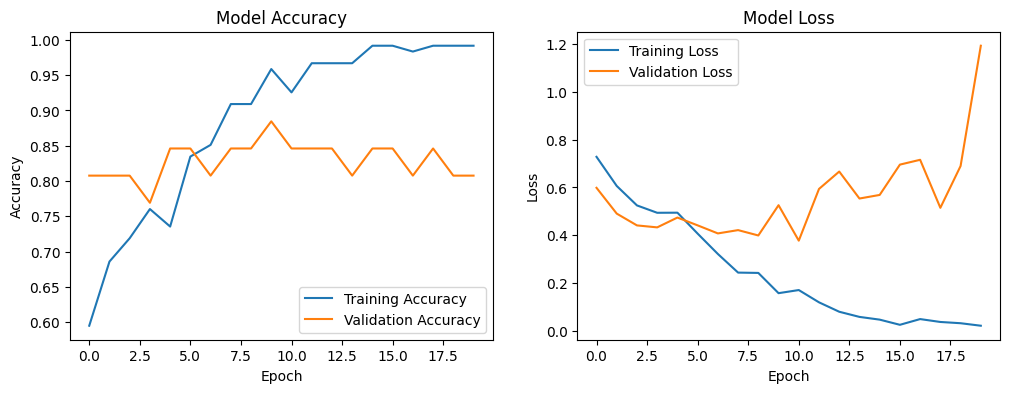

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


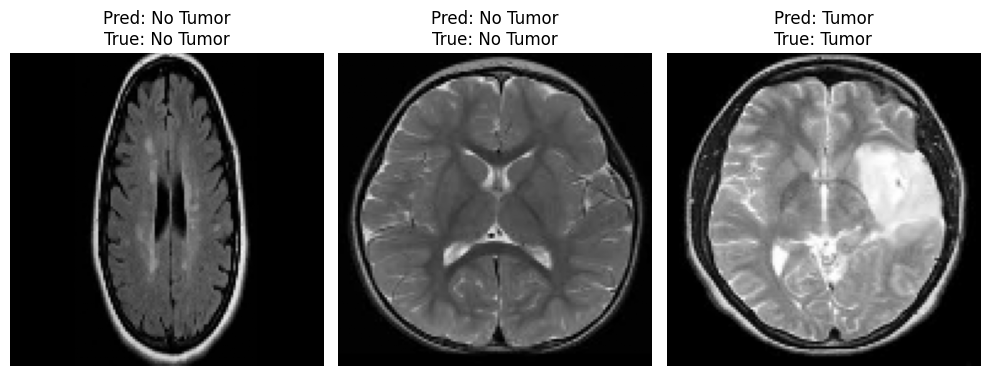

In [17]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save model
model.save('brain_tumor_cnn_model.h5')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize sample predictions
predictions = model.predict(X_test[:3])
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(X_test[i])
    plt.title(f'Pred: {"Tumor" if predictions[i] > 0.5 else "No Tumor"}\nTrue: {"Tumor" if y_test[i] == 1 else "No Tumor"}')
    plt.axis('off')
plt.tight_layout()
plt.show()